# Data Exploration and cleaning

In [122]:
import pandas as pd   
import numpy as np 
import matplotlib.pyplot as plt  
%matplotlib inline        
import seaborn as sns
import matplotlib.ticker as mtick

In [123]:
from IPython.display import display, HTML

class ColorfulLine:
    def __init__(self, border_color, background_color, height):
        self.border_color = border_color
        self.background_color = background_color
        self.height = height

    def create_line(self):
        line_style = f'border: 2px solid {self.border_color}; background-color: {self.background_color}; height: {self.height}px;'
        line_html = f'<div style="{line_style}"></div>'
        display(HTML(line_html))

# Instantiate the ColorfulLine class with desired parameters
line = ColorfulLine(border_color='#0000FF', background_color='#ADD8E6', height=5)
line.create_line()

# Importing and looking into data

In [124]:
train_data = pd.read_csv('csv_data/Training_set_values.csv')
train_target = pd.read_csv('csv_data/Training_set_labels.csv')

In [125]:
train_data

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59395,60739,10.0,2013-05-03,Germany Republi,1210,CES,37.169807,-3.253847,Area Three Namba 27,0,...,per bucket,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
59396,27263,4700.0,2011-05-07,Cefa-njombe,1212,Cefa,35.249991,-9.070629,Kwa Yahona Kuvala,0,...,annually,soft,good,enough,enough,river,river/lake,surface,communal standpipe,communal standpipe
59397,37057,0.0,2011-04-11,NaN,0,NaN,34.017087,-8.750434,Mashine,0,...,monthly,fluoride,fluoride,enough,enough,machine dbh,borehole,groundwater,hand pump,hand pump
59398,31282,0.0,2011-03-08,Malec,0,Musa,35.861315,-6.378573,Mshoro,0,...,never pay,soft,good,insufficient,insufficient,shallow well,shallow well,groundwater,hand pump,hand pump


In [126]:
train_data.set_index('id',inplace=True)
train_target.set_index('id',inplace=True)

>- Afrter exploting the outer and inner merge, decided there's the same number of entries with the same id number as primary key 

In [127]:
train_data = train_data.merge(train_target, on ='id')

In [128]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 59400 entries, 69572 to 26348
Data columns (total 40 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   amount_tsh             59400 non-null  float64
 1   date_recorded          59400 non-null  object 
 2   funder                 55763 non-null  object 
 3   gps_height             59400 non-null  int64  
 4   installer              55745 non-null  object 
 5   longitude              59400 non-null  float64
 6   latitude               59400 non-null  float64
 7   wpt_name               59398 non-null  object 
 8   num_private            59400 non-null  int64  
 9   basin                  59400 non-null  object 
 10  subvillage             59029 non-null  object 
 11  region                 59400 non-null  object 
 12  region_code            59400 non-null  int64  
 13  district_code          59400 non-null  int64  
 14  lga                    59400 non-null  object 
 15  war

In [129]:
line.create_line()

# Cleaning and Understanding our numeric values
>- None of our numeric values are null but lets make sure that's true
>- We can see from the .describe that logtitude has some 0 values which is a line that doesn't pass by TZ
>>- Leading us to conclude 0 represents null values
>>- We can't impute logtitude so we'll omite for modeling later on
>>- We'll also drop latitude for modeling
>- num_private wasn't given any specific information from our data source
>>-  Droping it for now
>- amount_tsh measures water availability but 50% of the data is 0
>>- which isn't consistent with our target output with over 60% being functional
>>- Imputing will lead to skewed results, therefore dropping it 
>- Region code seems to be having false representation
>>- Arusha has code 2 and it's assigned 2 and 24 in the data
>>- Dropping it for now
>- District code doesn't seem to offer much insight
>>- It's a categorical feature since districts aren't numbered in TZ
>>- Repeating number for different region district code could create false narrative
>>- Hence will be dropping the column
>- Some 0's in population might be null values but we'll leave it for now
>>- The data is skewed to the right but we can use standard scaler and impute 0 values with mean
>- Constraction year can't be zero so those are null values
>>- Will be using the median value from data excluding zero to impute

In [130]:
train_data.status_group.value_counts(normalize=True)

status_group
functional                 0.543081
non functional             0.384242
functional needs repair    0.072677
Name: proportion, dtype: float64

In [131]:
train_data.describe()

,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year
count,59400.000000,59400.000000,59400.000000,5.940000e+04,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000
mean,317.650385,668.297239,34.077427,-5.706033e+00,0.474141,15.297003,5.629747,179.909983,1300.652475
std,2997.574558,693.116350,6.567432,2.946019e+00,12.236230,17.587406,9.633649,471.482176,951.620547
min,0.000000,-90.000000,0.000000,-1.164944e+01,0.000000,1.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,33.090347,-8.540621e+00,0.000000,5.000000,2.000000,0.000000,0.000000
50%,0.000000,369.000000,34.908743,-5.021597e+00,0.000000,12.000000,3.000000,25.000000,1986.000000
75%,20.000000,1319.250000,37.178387,-3.326156e+00,0.000000,17.000000,5.000000,215.000000,2004.000000
max,350000.000000,2770.000000,40.345193,-2.000000e-08,1776.000000,99.000000,80.000000,30500.000000,2013.000000


In [132]:
train_data.groupby(['region', 'district_code','region_code']).count()

amount_tsh  date_recorded  funder  \
region district_code region_code                                      
Arusha 1             2                   189            189       0   
       2             2                  1206           1206    1204   
       3             2                   109            109       0   
       5             2                   201            201     201   
       6             2                   310            310     299   
...                                      ...            ...     ...   
Tanga  4             4                   110            110     110   
       5             4                   293            293     293   
       6             4                   266            266     266   
       7             4                   127            127     127   
       8             4                   288            288     288   

                                  gps_height  installer  longitude  latitude  \
region district_code region_code                                               
Arusha 1             2                   189          0        189       189   
       2             2                  1206       1206       1206      1206   
       3             2                   109          0        109       109   
       5             2                   201        200        201       201   
       6             2                   310        299        310       310   
...                                      ...        ...        ...       ...   
Tanga  4             4                   110        110        110       110   
       5             4                   293        293        293       293   
       6             4                   266        266        266       266   
       7             4                   127        127        127       127   
       8             4                   288        288        288       288   

                                  wpt_name  num_private  basin  ...  \
region district_code region_code                                ...   
Arusha 1             2                 189          189    189  ...   
       2             2                1206         1206   1206  ...   
       3             2                 109          109    109  ...   
       5             2                 201          201    201  ...   
       6             2                 310          310    310  ...   
...                                    ...          ...    ...  ...   
Tanga  4             4                 110          110    110  ...   
       5             4                 293          293    293  ...   
       6             4                 266          266    266  ...   
       7             4                 127          127    127  ...   
       8             4                 288          288    288  ...   

                                  water_quality  quality_group  quantity  \
region district_code region_code                                           
Arusha 1             2                      189            189       189   
       2             2                     1206           1206      1206   
       3             2                      109            109       109   
       5             2                      201            201       201   
       6             2                      310            310       310   
...                                         ...            ...       ...   
Tanga  4             4                      110            110       110   
       5             4                      293            293       293   
       6             4                      266            266       266   
       7             4                      127            127       127   
       8             4                      288            288       288   

                                  quantity_group  source  source_type  \
region district_code region_code                                        
Arusha 1  

In [133]:
# Implementing the notes above from exploring data 
from sklearn.impute import SimpleImputer

# Drop numerical columns
train_data.drop(['longitude', 'latitude', 'num_private', 'amount_tsh', 'region_code', 'district_code'], axis=1, inplace=True)

# Impute population column
population_imputer = SimpleImputer(strategy='mean')
train_data['population'] = population_imputer.fit_transform(train_data['population'].values.reshape(-1, 1))

# Replace construction_year column with 2000
train_data.loc[train_data['construction_year'] == 0, 'construction_year'] = 2000

# Creating a new column called age for how old the schemes are from construction - current
from datetime import datetime
train_data['age_of_well']=datetime.now().year - train_data['construction_year']

In [134]:
line.create_line()

# Cleaning and Understanding the categorical values

#### The .info highlights entries that might be duplicate from the get go so we'll look into similar column names
>- scheme_management, management, & management_group
>>- They all include managment types, with managment group having better general information of managment
>>- It groups user groups, commercial, authority, other and rest as unknown
>>- Will be dropping managment_types and scheme_managment for now
>- subvillage, lga, region,& ward
>>- All these columns pertain locational information
>>- There's a lot of information to OHE in columns lga, ward and subvillage
>>- Will be dropping them for now and keep region
>- extraction_type, extraction_type_group, extraction_type_class
>>- They all have similar information on extraction type
>>- extraction_type_group And extraction_type have a lot of duplicate entries so will drop them
>>- Keeing extraction_type_class as it has more dependable data
>- payment & payment_type
>>- Both columns have the same information and will be dropping payment_type
>- quality_group, quantity, quantity_group &  water_quality
>>- Water quality and quality_group have the same information
>>- water_quality includes two of floride and salty qualirt as abondaned and not
>>- That information isn't consitant for other quality entries
>>- Will be droping water_quality and remane quality_group as water quality
>>- Quantity and quantity_group have the same information
>>- keeping quantity and droping quantity_group
>- source, source_type, source_class
>>- Source_type and source have the same information and will drop source_type
>- waterpoint_type & waterpoint_type_group
>>- The two columns above also contain the same information
>>- Droping waterpoint_type since it has duplicate entries
>- wpt_name & scheme_name
>>- Both seem to have names of schemes with scheme_names having multiple single letter entry
>>- These features are currently not important for this analysis and will drop for now

In [135]:
train_data.groupby(['wpt_name', 'scheme_name']).count().head(50)

,,date_recorded,funder,gps_height,installer,basin,subvillage,region,lga,ward,population,...,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group,age_of_well
wpt_name,scheme_name,,,,,,,,,,,,,,,,,,,,,
A Kulwa,Nyamtukuza,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
Abass,Magat gravity spring,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
Abbas,Chalinze wate,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
Abdalaa,S,1,0,1,0,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
Abdalah,N,1,0,1,0,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
Abdalah Miliki,Riv,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
Abdalamani Mussa,Kitopeni,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
Abdallah Miwani,S,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
Abdallah Mponzi,Ki,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


In [136]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 59400 entries, 69572 to 26348
Data columns (total 35 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   date_recorded          59400 non-null  object 
 1   funder                 55763 non-null  object 
 2   gps_height             59400 non-null  int64  
 3   installer              55745 non-null  object 
 4   wpt_name               59398 non-null  object 
 5   basin                  59400 non-null  object 
 6   subvillage             59029 non-null  object 
 7   region                 59400 non-null  object 
 8   lga                    59400 non-null  object 
 9   ward                   59400 non-null  object 
 10  population             59400 non-null  float64
 11  public_meeting         56066 non-null  object 
 12  recorded_by            59400 non-null  object 
 13  scheme_management      55522 non-null  object 
 14  scheme_name            30590 non-null  object 
 15  per

In [137]:
# Drop categorical columns
train_data.drop(['scheme_management', 'management', 'subvillage', 'lga', 'ward', 'extraction_type_group', 
                 'extraction_type', 'payment_type', 'water_quality', 'quantity_group', 'source_type', 
                 'waterpoint_type', 'wpt_name', 'scheme_name'], axis=1, inplace=True)

# Rename quality_group column to become water_quality
train_data.rename(columns={'quality_group': 'water_quality'}, inplace=True)

In [138]:
line.create_line()

#### We'll now look into null values of categorical columns
>- There's 3637 missing from funder
>- 3655 from installer, 3056 from permit
>- And 3334 from public_meeting

#### Imputing and grouping 
>- There's a long list of funders and installers
>- To make our OHE easier, we'll mention top 5 and group the rest as others
>- Substantial amount of the water schemes have permit
>- We'll impute missing values with most_frequent to not lose data

In [139]:
train_data.funder.value_counts().head()

funder
Government Of Tanzania    9084
Danida                    3114
Hesawa                    2202
Rwssp                     1374
World Bank                1349
Name: count, dtype: int64

In [140]:
train_data.isna().sum()

date_recorded               0
funder                   3637
gps_height                  0
installer                3655
basin                       0
region                      0
population                  0
public_meeting           3334
recorded_by                 0
permit                   3056
construction_year           0
extraction_type_class       0
management_group            0
payment                     0
water_quality               0
quantity                    0
source                      0
source_class                0
waterpoint_type_group       0
status_group                0
age_of_well                 0
dtype: int64

In [141]:
train_data.permit = train_data.permit.fillna('Unknown')
most_frequent_permit = train_data.permit.mode()[0]
train_data.permit = train_data.permit.replace('Unknown', most_frequent_permit)

train_data.public_meeting = train_data.public_meeting.fillna('Unknown')
most_frequent_meeting = train_data.public_meeting.mode()[0]
train_data.public_meeting = train_data.public_meeting.replace('Unknown', most_frequent_meeting)

In [142]:
# Impute missing values in 'funder' and 'installer' columns
imputer = SimpleImputer(strategy='most_frequent')
train_data[['funder', 'installer']] = imputer.fit_transform(train_data[['funder', 'installer']])

# Group 'funder' and 'installer' columns
top_funders = train_data['funder'].value_counts().nlargest(6).index
train_data.loc[~train_data['funder'].isin(top_funders), 'funder'] = 'Others'

top_installers = train_data['installer'].value_counts().nlargest(6).index
train_data.loc[~train_data['installer'].isin(top_installers), 'installer'] = 'Others'

In [143]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 59400 entries, 69572 to 26348
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   date_recorded          59400 non-null  object 
 1   funder                 59400 non-null  object 
 2   gps_height             59400 non-null  int64  
 3   installer              59400 non-null  object 
 4   basin                  59400 non-null  object 
 5   region                 59400 non-null  object 
 6   population             59400 non-null  float64
 7   public_meeting         59400 non-null  bool   
 8   recorded_by            59400 non-null  object 
 9   permit                 59400 non-null  bool   
 10  construction_year      59400 non-null  int64  
 11  extraction_type_class  59400 non-null  object 
 12  management_group       59400 non-null  object 
 13  payment                59400 non-null  object 
 14  water_quality          59400 non-null  object 
 15  qua

In [144]:
train_data.installer.value_counts().head()

installer
Others        32304
DWE           21057
Government     1825
RWE            1206
Commu          1060
Name: count, dtype: int64

In [145]:
line.create_line()

# There's no longer null columns
#### Will now explore the data and it's relationship with target values

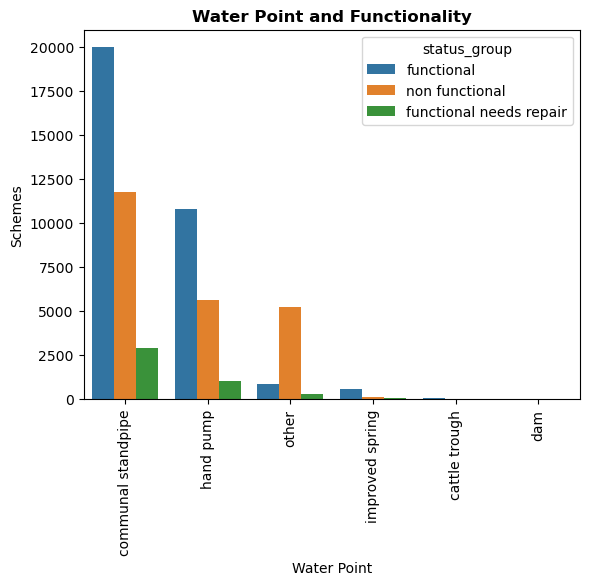

In [146]:
plt.figure("Water Point Types And Functionality")
ax = sns.countplot(x='waterpoint_type_group', hue="status_group", data=train_data)
ax.set_xticklabels(ax.get_xticklabels(), rotation='vertical')
plt.xlabel('Water Point');
plt.ylabel('Schemes');
plt.title('Water Point and Functionality',fontsize=12, fontweight='bold');

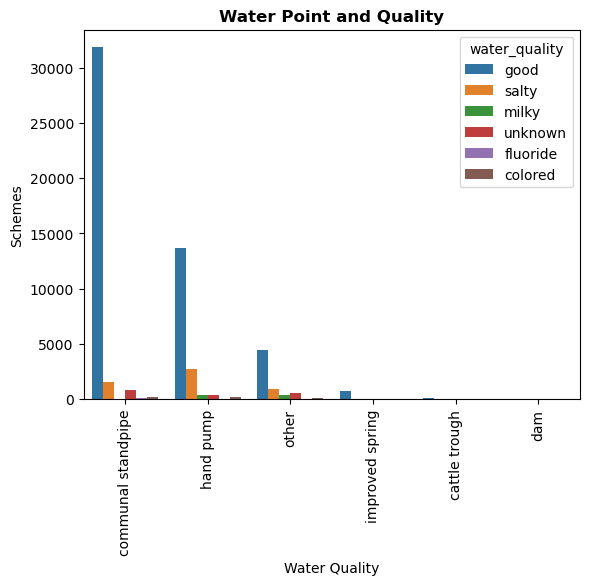

In [147]:
plt.figure("Water Point Types And Functionality")
ax = sns.countplot(x='waterpoint_type_group', hue="water_quality", data=train_data)
ax.set_xticklabels(ax.get_xticklabels(), rotation='vertical')
plt.xlabel('Water Quality');
plt.ylabel('Schemes');
plt.title('Water Point and Quality',fontsize=12, fontweight='bold');

[Text(0, 0, 'good'),
 Text(1, 0, 'salty'),
 Text(2, 0, 'milky'),
 Text(3, 0, 'unknown'),
 Text(4, 0, 'fluoride'),
 Text(5, 0, 'colored')]

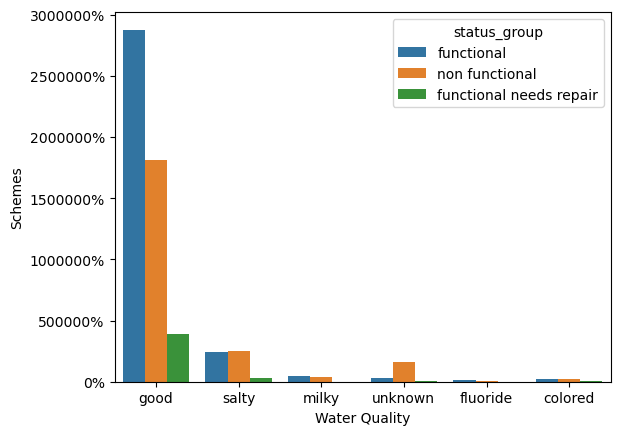

In [148]:
plt.figure("Water Quality And Functionality")
ax = sns.countplot(x='water_quality', hue="status_group", data=train_data)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.xlabel('Water Quality');
plt.ylabel('Schemes');
ax.set_xticklabels(ax.get_xticklabels())

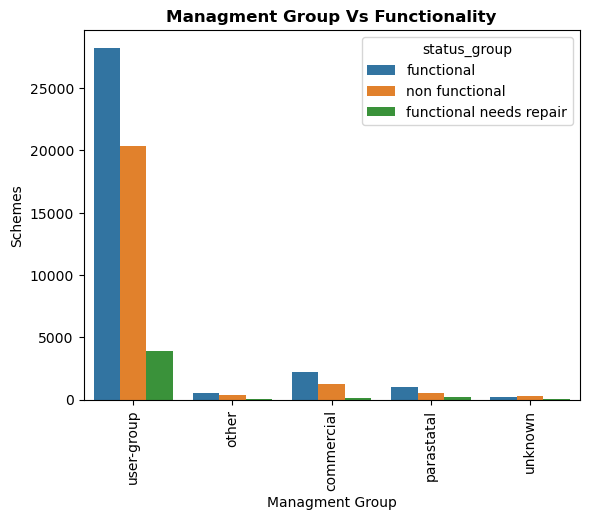

In [149]:
ax = sns.countplot(x='management_group', hue="status_group", data=train_data)
ax.set_xticklabels(ax.get_xticklabels(), rotation='vertical')
plt.xlabel('Managment Group');
plt.ylabel('Schemes');
plt.title('Managment Group Vs Functionality',fontsize=12, fontweight='bold');

In [150]:
line.create_line()

# Grouping target as Functional and Needs Repair for Modeling Purposes
>- 1 representing Functional water pumps
>- 0 representing those that need repair

In [151]:
train_data.status_group.value_counts(normalize=True)

status_group
functional                 0.543081
non functional             0.384242
functional needs repair    0.072677
Name: proportion, dtype: float64

In [152]:
vals_to_replace = {'functional':1, 'functional needs repair':0,
                   'non functional':0}

train_data['status_group']  = train_data.status_group.replace(vals_to_replace)

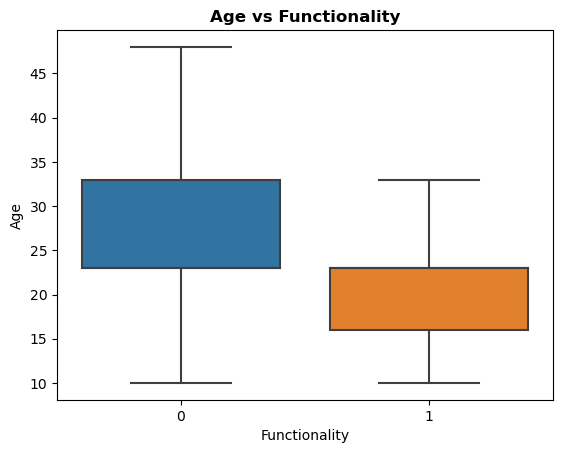

In [153]:
sns.boxplot(x='status_group',y='age_of_well', data=train_data, showfliers=False)
plt.xlabel('Functionality');
plt.ylabel('Age');
plt.title('Age vs Functionality',fontsize=12, fontweight='bold');

In [154]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 59400 entries, 69572 to 26348
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   date_recorded          59400 non-null  object 
 1   funder                 59400 non-null  object 
 2   gps_height             59400 non-null  int64  
 3   installer              59400 non-null  object 
 4   basin                  59400 non-null  object 
 5   region                 59400 non-null  object 
 6   population             59400 non-null  float64
 7   public_meeting         59400 non-null  bool   
 8   recorded_by            59400 non-null  object 
 9   permit                 59400 non-null  bool   
 10  construction_year      59400 non-null  int64  
 11  extraction_type_class  59400 non-null  object 
 12  management_group       59400 non-null  object 
 13  payment                59400 non-null  object 
 14  water_quality          59400 non-null  object 
 15  qua

In [155]:
line.create_line()

### Saving data as csv for modeling notebook

In [156]:
train_data.to_csv('train_data.csv')